# Proyek Klasifikasi Gambar: Arabic Handwritten Characters
- Ridwan Halim
- erbyl14@gmail.com
- id dicoding: ridwaanhall

## First of All

### Install

### Import

In [2]:
import os
import requests
import zipfile
from PIL import Image
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflowjs as tfjs
import random
from tensorflow.keras import layers, models
from IPython.display import Image as IPImage
from tensorflow.keras.callbacks import Callback

In [3]:
print(tf.__version__)

2.16.2


In [21]:
required_packages = [
    'os',
    'requests',
    'zipfile',
    'PIL',
    'pandas',
    'numpy',
    'tensorflow',
    'scikit-learn',
    'matplotlib',
    'tensorflowjs',
    'random',
    'IPython'
]

with open('requirements.txt', 'w') as f:
    for package in required_packages:
        try:
            version = !pip show {package} | grep Version
            version = version[0].split(' ')[1] if version else 'Not Installed'
            f.write(f"{package}=={version}\n")
        except Exception as e:
            f.write(f"{package}==Version not found\n")
            print(f"Could not find version for {package}: {e}")

print("requirements.txt created successfully!")

requirements.txt created successfully!


## Dataset Manager

In [4]:
arabic_labels = {
    1: "Alef (أ)",
    2: "Bah (ب)",
    3: "Teh (ت)",
    4: "Theh (ث)",
    5: "Jeem (ج)",
    6: "Hah (ح)",
    7: "Khah (خ)",
    8: "Dal (د)",
    9: "Thal (ذ)",
    10: "Reh (ر)",
    11: "Zay (ز)",
    12: "Seen (س)",
    13: "Sheen (ش)",
    14: "Sad (ص)",
    15: "Dad (ض)",
    16: "Tah (ط)",
    17: "Zah (ظ)",
    18: "Ain (ع)",
    19: "Ghain (غ)",
    20: "Feh (ف)",
    21: "Qaf (ق)",
    22: "Kaf (ك)",
    23: "Lam (ل)",
    24: "Meem (م)",
    25: "Noon (ن)",
    26: "Heh (هـ)",
    27: "Waw (و)",
    28: "Yeh (ي)"
}

class DatasetManager:
    def __init__(self, url, dataset_dir):
        self.url = url
        self.dataset_path = os.path.basename(url)
        self.dataset_dir = dataset_dir

    def download_dataset(self):
        print("Downloading dataset...")
        response = requests.get(self.url)
        with open(self.dataset_path, 'wb') as file:
            file.write(response.content)
        print("Download complete.")

    def extract_dataset(self):
        print("Extracting dataset...")
        with zipfile.ZipFile(self.dataset_path, 'r') as zip_ref:
            zip_ref.extractall(self.dataset_dir)
        print("Extraction complete.")

    def check_image_resolutions(self, image_dir):
        print("Checking image resolutions...")
        resolution_counts = {}

        for image_name in os.listdir(image_dir):
            image_path = os.path.join(image_dir, image_name)
            with Image.open(image_path) as img:
                resolution = img.size  # (width, height)
                if resolution in resolution_counts:
                    resolution_counts[resolution] += 1
                else:
                    resolution_counts[resolution] = 1

        df = pd.DataFrame(list(resolution_counts.items()), columns=['Resolution', 'Count'])
        df['Resolution'] = df['Resolution'].apply(lambda x: f"{x[0]}x{x[1]}")
        return df

    def resize_images(self, image_dir, output_dir, new_size):
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        image_files = os.listdir(image_dir)
        for image_name in image_files:
            image_path = os.path.join(image_dir, image_name)
            with Image.open(image_path) as img:
                resized_img = img.resize(new_size, Image.LANCZOS)
                base_name, ext = os.path.splitext(image_name)
                new_image_name = f"{base_name}{ext}"
                resized_img.save(os.path.join(output_dir, new_image_name))

    def organize_images_by_label(self, image_dir):
        print("Organizing images by label...")
        for image_name in os.listdir(image_dir):
            # Extract label from filename
            if 'label_' in image_name:
                try:
                    label_number = int(image_name.split('label_')[1].split('.')[0])
                    arabic_label = arabic_labels.get(label_number, 'Unknown')

                    if arabic_label == 'Unknown':
                        print(f"Skipping file {image_name} as the label '{label_number}' is not recognized.")
                        continue

                    label_dir = os.path.join(image_dir, arabic_label)
                    if not os.path.exists(label_dir):
                        os.makedirs(label_dir)

                    image_path = os.path.join(image_dir, image_name)
                    new_image_path = os.path.join(label_dir, image_name)
                    os.rename(image_path, new_image_path)
                except ValueError:
                    print(f"Skipping file {image_name} due to invalid label format.")
            else:
                print(f"Skipping file {image_name} as it does not have a label.")
        print("Images organized by label.")

    def count_and_display_label_folders(self, base_dir):
        print("Counting and displaying label folders...")
        label_folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]
        folder_count = len(label_folders)
        print(f"Total number of label folders: {folder_count}")
        print("Label folders:")
        for folder in label_folders:
            folder_path = os.path.join(base_dir, folder)
            file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
            print(f"- {folder}: {file_count} files")

    def read_random_image_from_each_folder(self, base_dir):
        print(f"Reading random image from each folder in directory: {base_dir}")
        folder_paths = [os.path.join(base_dir, folder) for folder in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, folder))]

        for folder_path in folder_paths:
            image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
            if not image_files:
                print(f"No image files found in directory: {folder_path}")
                continue

            random_image_name = random.choice(image_files)
            random_image_path = os.path.join(folder_path, random_image_name)

            display(IPImage(filename=random_image_path))  # Display the image in the notebook
            print(f"Displayed image from folder '{os.path.basename(folder_path)}': {random_image_name}")

In [5]:
url = 'https://github.com/ridwaanhall/datasets/raw/main/arabic_handwritten_chars_image_all_13440_diff.zip'
dataset_dir = 'arabic_handwritten_chars_image_all_13440_diff'
output_dir = 'arabic_handwritten_chars_image_all_13440_32x32'
new_size = (32, 32)

dataset_manager = DatasetManager(url, dataset_dir)

### Download and Extract

In [6]:
dataset_manager.download_dataset()
dataset_manager.extract_dataset()

Download complete.
Extracting dataset...
Extraction complete.


### Check Resolution

In [7]:
df_before_resize = dataset_manager.check_image_resolutions(dataset_dir)
print("Resolutions before resizing:")
print(df_before_resize)

Checking image resolutions...
Resolutions before resizing:
    Resolution  Count
0      180x180    142
1      178x178    147
2      188x188    131
3      135x135    152
4      128x128    138
..         ...    ...
96     182x182    126
97     145x145    132
98     174x174    154
99     139x139    118
100    176x176    128

[101 rows x 2 columns]


### Resize to 32x32

In [8]:
dataset_manager.resize_images(dataset_dir, output_dir, new_size)

### Check Resolution after Resize

In [9]:
df_after_resize = dataset_manager.check_image_resolutions(output_dir)
print("Resolutions after resizing:")
print(df_after_resize)

Checking image resolutions...
Resolutions after resizing:
  Resolution  Count
0      32x32  13440


### Organize Label

In [10]:
dataset_manager.organize_images_by_label(output_dir)

Organizing images by label...
Images organized by label.


### Count Label Folder and Files

In [11]:
dataset_manager.count_and_display_label_folders(output_dir)

Counting and displaying label folders...
Total number of label folders: 28
Label folders:
- Dad (ض): 480 files
- Alef (أ): 480 files
- Seen (س): 480 files
- Ghain (غ): 480 files
- Feh (ف): 480 files
- Jeem (ج): 480 files
- Sheen (ش): 480 files
- Sad (ص): 480 files
- Lam (ل): 480 files
- Teh (ت): 480 files
- Noon (ن): 480 files
- Heh (هـ): 480 files
- Reh (ر): 480 files
- Waw (و): 480 files
- Zah (ظ): 480 files
- Bah (ب): 480 files
- Theh (ث): 480 files
- Tah (ط): 480 files
- Meem (م): 480 files
- Thal (ذ): 480 files
- Ain (ع): 480 files
- Khah (خ): 480 files
- Zay (ز): 480 files
- Yeh (ي): 480 files
- Qaf (ق): 480 files
- Dal (د): 480 files
- Hah (ح): 480 files
- Kaf (ك): 480 files


### Read Image random

Reading random image from each folder in directory: arabic_handwritten_chars_image_all_13440_32x32


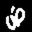

Displayed image from folder 'Dad (ض)': id_564_label_15.png


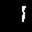

Displayed image from folder 'Alef (أ)': id_2469_label_1.png


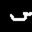

Displayed image from folder 'Seen (س)': id_2779_label_12.png


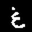

Displayed image from folder 'Ghain (غ)': id_8660_label_19.png


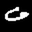

Displayed image from folder 'Feh (ف)': id_13152_label_20.png


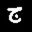

Displayed image from folder 'Jeem (ج)': id_11463_label_5.png


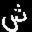

Displayed image from folder 'Sheen (ش)': id_550_label_13.png


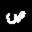

Displayed image from folder 'Sad (ص)': id_11982_label_14.png


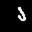

Displayed image from folder 'Lam (ل)': id_856_label_23.png


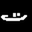

Displayed image from folder 'Teh (ت)': id_3827_label_3.png


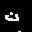

Displayed image from folder 'Noon (ن)': id_4674_label_25.png


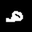

Displayed image from folder 'Heh (هـ)': id_8489_label_26.png


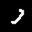

Displayed image from folder 'Reh (ر)': id_11499_label_10.png


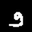

Displayed image from folder 'Waw (و)': id_10963_label_27.png


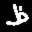

Displayed image from folder 'Zah (ظ)': id_355_label_17.png


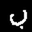

Displayed image from folder 'Bah (ب)': id_2025_label_2.png


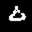

Displayed image from folder 'Theh (ث)': id_9888_label_4.png


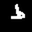

Displayed image from folder 'Tah (ط)': id_4384_label_16.png


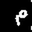

Displayed image from folder 'Meem (م)': id_5344_label_24.png


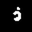

Displayed image from folder 'Thal (ذ)': id_8808_label_9.png


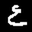

Displayed image from folder 'Ain (ع)': id_10889_label_18.png


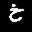

Displayed image from folder 'Khah (خ)': id_727_label_7.png


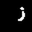

Displayed image from folder 'Zay (ز)': id_9048_label_11.png


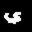

Displayed image from folder 'Yeh (ي)': id_11199_label_28.png


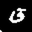

Displayed image from folder 'Qaf (ق)': id_3303_label_21.png


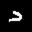

Displayed image from folder 'Dal (د)': id_11708_label_8.png


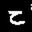

Displayed image from folder 'Hah (ح)': id_11696_label_6.png


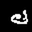

Displayed image from folder 'Kaf (ك)': id_1296_label_22.png


In [12]:
dataset_manager.read_random_image_from_each_folder(output_dir)

## Data Splitter

In [13]:
class DataSplitter:
    def __init__(self, image_dir, test_size=0.2, image_size=(32, 32), batch_size=32):
        self.image_dir = image_dir
        self.test_size = test_size
        self.image_size = image_size
        self.batch_size = batch_size

    def preprocess_image(self, image):
        image = 1.0 - image
        return image

    def split_data(self):
        dataset = tf.keras.preprocessing.image_dataset_from_directory(
            self.image_dir,
            image_size=self.image_size,
            batch_size=self.batch_size,
            shuffle=True
        )
        dataset = dataset.map(lambda x, y: (self.preprocess_image(x), y))

        train_size = int((1 - self.test_size) * len(dataset))
        train_dataset = dataset.take(train_size)
        test_dataset = dataset.skip(train_size)
        return train_dataset, test_dataset

data_splitter = DataSplitter(image_dir='/content/arabic_handwritten_chars_image_all_13440_32x32')
train_dataset, test_dataset = data_splitter.split_data()

Found 13440 files belonging to 28 classes.


## Model Builder

In [14]:
class ModelBuilder:
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build_model(self):
        model = models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(512, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(256, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(self.num_classes, activation='softmax')
        ])
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model

input_shape = (32, 32, 3)
num_classes = len(os.listdir('/content/arabic_handwritten_chars_image_all_13440_32x32'))

model_builder = ModelBuilder(input_shape=input_shape, num_classes=num_classes)
model = model_builder.build_model()
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 30, 30, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 13, 13, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4, 4, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 28)                  │           7,196 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 498,396 (1.90 MB)

 Trainable params: 496,412 (1.89 MB)

 Non-trainable params: 1,984 (7.75 KB)

## Model Trainer

In [15]:
class EarlyStoppingByAccuracy(Callback):
    def __init__(self, accuracy_threshold=0.95):
        super(EarlyStoppingByAccuracy, self).__init__()
        self.accuracy_threshold = accuracy_threshold

    def on_epoch_end(self, epoch, logs=None):
        train_acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')

        if train_acc >= self.accuracy_threshold and val_acc >= self.accuracy_threshold:
            print(f"\nEpoch {epoch}: Reached {self.accuracy_threshold * 100}% accuracy, stopping training...")
            self.model.stop_training = True

class ModelTrainer:
    def __init__(self, model, train_dataset, val_dataset):
        self.model = model
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset

    def train_model(self, epochs=60):
        early_stopping_acc = EarlyStoppingByAccuracy(accuracy_threshold=0.95)

        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001),
            tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min'),
            early_stopping_acc
        ]

        history = self.model.fit(
            self.train_dataset,
            epochs=epochs,
            validation_data=self.val_dataset,
            callbacks=callbacks
        )
        return history

model_trainer = ModelTrainer(model=model, train_dataset=train_dataset, val_dataset=test_dataset)
history = model_trainer.train_model(epochs=100)

Epoch 1/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.2796 - loss: 2.8461 - val_accuracy: 0.7113 - val_loss: 0.8512 - learning_rate: 0.0010
Epoch 2/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.6553 - loss: 1.0513 - val_accuracy: 0.7894 - val_loss: 0.6266 - learning_rate: 0.0010
Epoch 3/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.7742 - loss: 0.7021 - val_accuracy: 0.8828 - val_loss: 0.3555 - learning_rate: 0.0010
Epoch 4/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8182 - loss: 0.5539 - val_accuracy: 0.8616 - val_loss: 0.4053 - learning_rate: 0.0010
Epoch 5/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8563 - loss: 0.4516 - val_accuracy: 0.9167 - val_loss: 0.2664 - learning_rate: 0.0010
Epoch 6/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8667 - loss: 0.3929 - val_accuracy: 0.9033 - val_loss: 0.3067 - learning_rate: 0.0010
Epoch 7/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8987 - 

## Model Evaluate

In [16]:
best_model = tf.keras.models.load_model('best_model.keras')

train_loss, train_acc = best_model.evaluate(train_dataset)
test_loss, test_acc = best_model.evaluate(test_dataset)

print(f"Train Accuracy: {train_acc:.2f}")
print(f"Validation Accuracy: {test_acc:.2f}")

336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9997 - loss: 0.0025
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9551 - loss: 0.1402
Train Accuracy: 1.00
Validation Accuracy: 0.95


## Plot

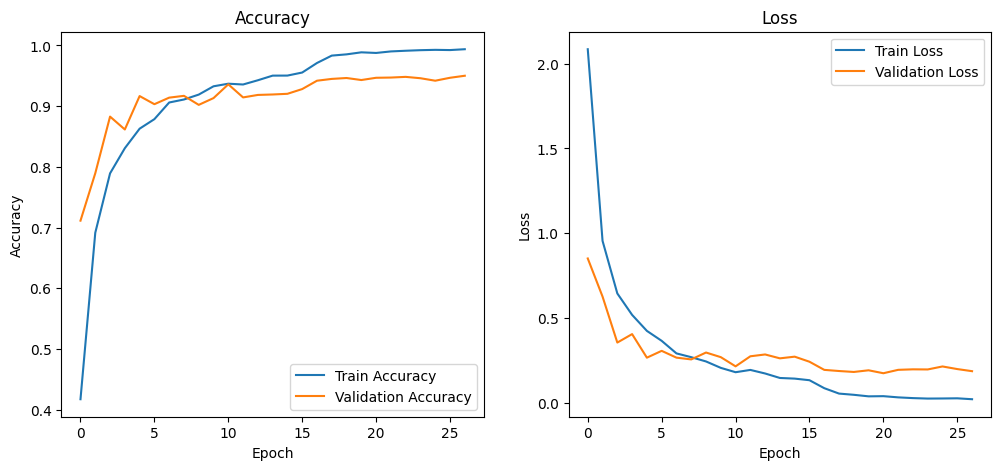

In [17]:
def plot_metrics(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()

plot_metrics(history)

## Save Model

##### new v2

In [18]:
class ModelSaver:
    def __init__(self, model, base_path='saved_models'):
        self.model = model
        self.base_path = base_path

    def save_all_formats(self):
        self.save_savedmodel()
        self.save_tfjs()
        self.save_tflite()

    def save_savedmodel(self):
        savedmodel_path = os.path.join(self.base_path, 'savedmodel')
        tf.saved_model.save(self.model, savedmodel_path)
        print(f"SavedModel format saved to: {savedmodel_path}")

    def save_tfjs(self):
        tfjs_path = os.path.join(self.base_path, 'tfjs')
        tfjs.converters.save_keras_model(self.model, tfjs_path)
        print(f"TFJS format saved to: {tfjs_path}")

    def save_tflite(self):
        tflite_path = os.path.join(self.base_path, 'model.tflite')
        converter = tf.lite.TFLiteConverter.from_keras_model(self.model)

        tflite_model = converter.convert()
        with open(tflite_path, 'wb') as f:
            f.write(tflite_model)
        print(f"TF-Lite format saved to: {tflite_path}")

# Usage
model_saver = ModelSaver(model=model)

###### Saved Model

In [19]:
model_saver.save_savedmodel()

SavedModel format saved to: saved_models/savedmodel


###### TFJS

In [20]:
model_saver.save_tfjs()

failed to lookup keras version from the file,
    this is likely a weight only file
TFJS format saved to: saved_models/tfjs


###### TF-Lite

In [23]:
!pip uninstall -y tensorflow
!pip install tensorflow==2.15.0

Found existing installation: tensorflow 2.16.2
Uninstalling tensorflow-2.16.2:
  Successfully uninstalled tensorflow-2.16.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 661.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 70.7 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
ERROR: pip's dependency resolver does not currently take into account all the

In [44]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [45]:
saved_model_path = '/content/saved_models/savedmodel'
tflite_model_path = '/content/saved_models/tflite_model/model_2.tflite'

model = tf.keras.models.load_model(saved_model_path, compile=False)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

os.makedirs(os.path.dirname(tflite_model_path), exist_ok=True)
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"TensorFlow Lite model saved to: {tflite_model_path}")

TensorFlow Lite model saved to: /content/saved_models/tflite_model/model_2.tflite


## Inverence

In [47]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [70]:
class ImageClassifier:
    def __init__(self, model_path, label_file_path):
        self.model_path = model_path
        self.label_file_path = label_file_path
        self.load_model()
        self.load_labels()

    def load_model(self):
        self.interpreter = tf.lite.Interpreter(model_path=self.model_path)
        self.interpreter.allocate_tensors()

    def load_labels(self):
        with open(self.label_file_path, 'r') as f:
            self.labels = [line.strip() for line in f.readlines()]

    def preprocess_image(self, img_path):
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(32, 32))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0  # Normalize
        return img_array

    def display_image(self, img_path):
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

    def predict_image(self, img_path):
        img_array = self.preprocess_image(img_path)
        self.interpreter.set_tensor(self.interpreter.get_input_details()[0]['index'], img_array)
        self.interpreter.invoke()
        output_data = self.interpreter.get_tensor(self.interpreter.get_output_details()[0]['index'])
        predicted_class_index = np.argmax(output_data[0])
        return self.labels[predicted_class_index]

model_path = '/content/saved_models/tflite_model/model.tflite'
label_file_path = '/content/saved_models/tflite_model/label.txt'

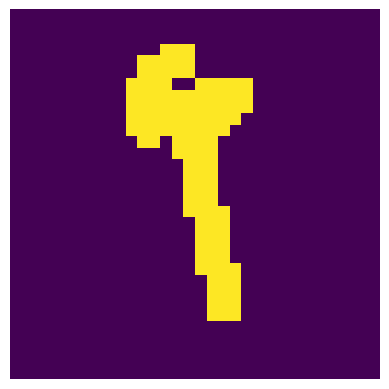

Predicted label: Alef (أ)


In [97]:
image_path = '/content/id_232_label_1.png'

classifier = ImageClassifier(model_path, label_file_path)
classifier.display_image(image_path)
predicted_label = classifier.predict_image(image_path)
print(f"Predicted label: {predicted_label}")

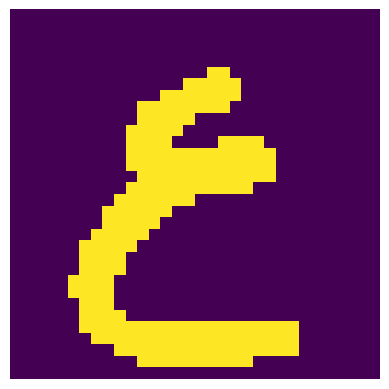

Predicted label: Ain (ع)


In [68]:
image_path = '/content/id_143_label_18.png'

classifier = ImageClassifier(model_path, label_file_path)
classifier.display_image(image_path)
predicted_label = classifier.predict_image(image_path)
print(f"Predicted label: {predicted_label}")

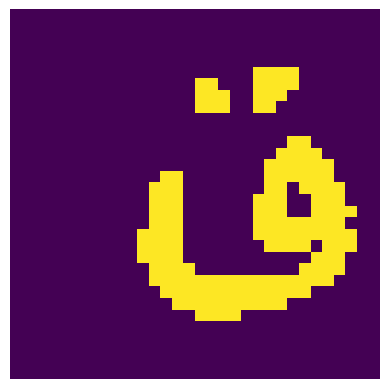

Predicted label: Qaf (ق)


In [92]:
image_path = '/content/id_155_label_20.png'

classifier = ImageClassifier(model_path, label_file_path)
classifier.display_image(image_path)
predicted_label = classifier.predict_image(image_path)
print(f"Predicted label: {predicted_label}")

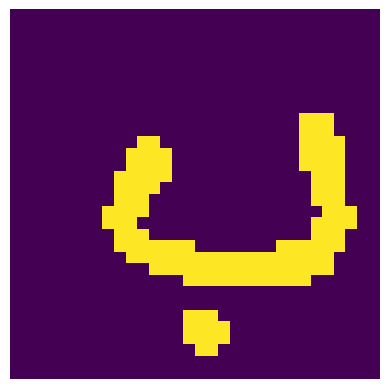

Predicted label: Bah (ب)


In [76]:
image_path = '/content/id_9_label_2.png'

classifier = ImageClassifier(model_path, label_file_path)
classifier.display_image(image_path)
predicted_label = classifier.predict_image(image_path)
print(f"Predicted label: {predicted_label}")

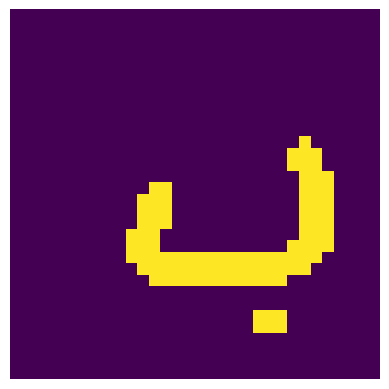

Predicted label: Bah (ب)


In [98]:
image_path = '/content/id_16_label_2.png'

classifier = ImageClassifier(model_path, label_file_path)
classifier.display_image(image_path)
predicted_label = classifier.predict_image(image_path)
print(f"Predicted label: {predicted_label}")

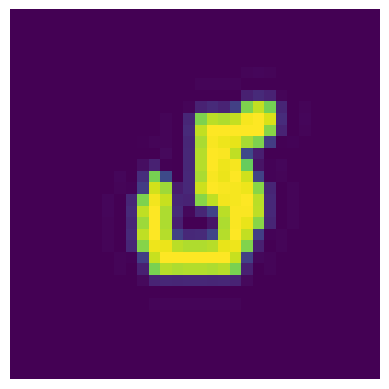

Predicted label: Qaf (ق)


In [89]:
image_path = '/content/arabic_handwritten_chars_image_all_13440_32x32/Qaf (ق)/id_10017_label_21.png'

classifier = ImageClassifier(model_path, label_file_path)
classifier.display_image(image_path)
predicted_label = classifier.predict_image(image_path)
print(f"Predicted label: {predicted_label}")